<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<H3 align='center'>  Jorge Portilla / John Rodriguez </H3>

<hr style="height:2px;border:none"/>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.callbacks import Callback
%matplotlib inline

Using TensorFlow backend.


## Pregunta 1

**a) Construya un dataframe con los datos a analizar y descríbalo brevemete. Además, realice la división de éste en los conjuntos de entrenamiento, validación y testeo correspondientes. Comente por qué se deben eliminar ciertas columnas**

In [3]:
df = pd.read_csv("EnergyMolecule/roboBohr.csv")
df.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total = len(df)

print(df.shape)
print(df.info())

dfTrain = df[:int(0.6*total)]
dfVal = df[int(0.6*total):int(0.85*total)]    
dfTest = df[int(0.85*total)::]

(16242, 1276)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Columns: 1276 entries, 0 to Eat
dtypes: float64(1276)
memory usage: 158.1 MB
None


Los datos corresponden a un csv compuesto de 1276 columnas correspondientes a las variables, y 16242 filas que corresponden a las diferentes simulaciones.

Las columnas 'Unnamed: 0' y 'pubchem_id' se eliminan por no tener datos relevante para los conjuntos de entrenamiento, validación y testeo. 'Unnamed: 0' no es necesaria debido a que corresponde a una enumeración, y el dataframe de panda ya viene con una incluída. 'pubchem_id' no es necesaria tampoco pues corresponde a la ID de la simulación.

**a.1) Una buena práctica es la de normalizar los datos antes de trabajar con el modelo. Explique por qué se aconseja dicho preprocesamiento**

Para un mejor funcionamiento de los algoritmos de Machine learning, hay que normalizar las variables de entrada del algoritmo, Normalizar, hace referencia a extender o comprimir los valores de una variable para estar en un rango definido. Es decir, realiza una ponderación de las caracterisiticas de una mejor manera y ademas se reduce el facor de escala. Sin embargo, realizar una mala eleccion del metodo de normalización puede alterar los resultados del analisis de datos. En este caso, se realiza una estandarización de los datos, debido a que si usamos normalización los outlayers podrían causar un desbalance de los datos en el intervalo, haciendo que muchos de ellos se agrupen cerca del 0.0 y que el outlayer quede como -1 o 1.


In [6]:
#Pre-processing#

#x var's
xTrain = pd.DataFrame.copy(dfTrain)
xVal = pd.DataFrame.copy(dfVal)
xTest = pd.DataFrame.copy(dfTest)

#y var's
yTrain = xTrain.pop('Eat').values.reshape(-1, 1)
yVal = xVal.pop('Eat').values.reshape(-1, 1)
yTest = xTest.pop('Eat').values.reshape(-1, 1)

#Scaler
scaler = StandardScaler().fit(xTrain)

#All standarized
xTrainScaled = pd.DataFrame(scaler.transform(xTrain),columns=xTrain.columns)
xValScaled = pd.DataFrame(scaler.transform(xVal),columns=xVal.columns)
xTestScaled = pd.DataFrame(scaler.transform(xTest),columns=xTest.columns)

**b) Muestre en un gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de *epochs* de entrenamiento, para una red *feedforward* de 3 capas, con 256 unidades ocultas y función de activación sigmoidal. Entrene la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 250 epochs de entrenamiento, en el conjunto de entrenamiento y de validación. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.**

Se crea un la red feedward de 3 capas como se especifica, para luego graficar el error obtenido en el entrenamiento y en las pruebas.

In [7]:
numEpochs = 250
test_loss = np.zeros(numEpochs)

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss = self.model.evaluate(x, y, verbose=0)
        test_loss[epoch-1] = loss
        print('\nTesting loss: {}'.format(loss))

In [9]:
model = Sequential()
model.add(Dense(256, input_dim=xTrainScaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear"))
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error') #, metrics=['accuracy']

history = model.fit(xTrainScaled.values,
                    yTrain,
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=(xValScaled.values, yVal), 
                    callbacks=[TestCallback((xTestScaled.values, yTest))])

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 626us/step - loss: 1.4313 - val_loss: 0.6044

Testing loss: 0.5724473738027098
Epoch 2/250
9745/9745 [==============================] - 4s 411us/step - loss: 0.6157 - val_loss: 0.4303

Testing loss: 0.4305726061920969
Epoch 3/250
9745/9745 [==============================] - 5s 512us/step - loss: 0.5055 - val_loss: 0.3991

Testing loss: 0.40601520367795246
Epoch 4/250
9745/9745 [==============================] - 5s 526us/step - loss: 0.4305 - val_loss: 0.4110

Testing loss: 0.3675703509058383
Epoch 5/250
9745/9745 [==============================] - 6s 595us/step - loss: 0.3684 - val_loss: 0.3072

Testing loss: 0.24977736251339297
Epoch 6/250
9745/9745 [==============================] - 5s 488us/step - loss: 0.3210 - val_loss: 0.2717

Testing loss: 0.23468143503637554
Epoch 7/250
9745/9745 [==============================] - 5s 532us/step - loss: 0.2817 - val_loss: 0.2685

Testing l

9745/9745 [==============================] - 5s 489us/step - loss: 0.0365 - val_loss: 0.0492

Testing loss: 0.034319982104611825
Epoch 60/250
9745/9745 [==============================] - 5s 526us/step - loss: 0.0363 - val_loss: 0.0694

Testing loss: 0.0499818189918787
Epoch 61/250
9745/9745 [==============================] - 5s 499us/step - loss: 0.0367 - val_loss: 0.0506

Testing loss: 0.034187185804668785
Epoch 62/250
9745/9745 [==============================] - 5s 485us/step - loss: 0.0358 - val_loss: 0.0643

Testing loss: 0.044643495670585884
Epoch 63/250
9745/9745 [==============================] - 4s 455us/step - loss: 0.0370 - val_loss: 0.0570

Testing loss: 0.05251148103090109
Epoch 64/250
9745/9745 [==============================] - 5s 480us/step - loss: 0.0350 - val_loss: 0.0540

Testing loss: 0.041686621165551954
Epoch 65/250
9745/9745 [==============================] - 4s 397us/step - loss: 0.0341 - val_loss: 0.0718

Testing loss: 0.06052834684144634
Epoch 66/250
9745/9745 

9745/9745 [==============================] - 4s 415us/step - loss: 0.0236 - val_loss: 0.0382

Testing loss: 0.03021039634371298
Epoch 118/250
9745/9745 [==============================] - 5s 468us/step - loss: 0.0231 - val_loss: 0.0438

Testing loss: 0.034768549179689634
Epoch 119/250
9745/9745 [==============================] - 5s 482us/step - loss: 0.0224 - val_loss: 0.0434

Testing loss: 0.03111838799537109
Epoch 120/250
9745/9745 [==============================] - 5s 473us/step - loss: 0.0235 - val_loss: 0.0394

Testing loss: 0.03082519530971788
Epoch 121/250
9745/9745 [==============================] - 6s 610us/step - loss: 0.0232 - val_loss: 0.0365

Testing loss: 0.030736748299572524
Epoch 122/250
9745/9745 [==============================] - 4s 460us/step - loss: 0.0236 - val_loss: 0.0378

Testing loss: 0.031963985508088454
Epoch 123/250
9745/9745 [==============================] - 4s 419us/step - loss: 0.0225 - val_loss: 0.0453

Testing loss: 0.03772967126393201
Epoch 124/250
974


Testing loss: 0.028655287316302125
Epoch 175/250
9745/9745 [==============================] - 5s 549us/step - loss: 0.0185 - val_loss: 0.0487

Testing loss: 0.04945908504116716
Epoch 176/250
9745/9745 [==============================] - 5s 472us/step - loss: 0.0185 - val_loss: 0.0346

Testing loss: 0.028653779148116898
Epoch 177/250
9745/9745 [==============================] - 4s 416us/step - loss: 0.0180 - val_loss: 0.0361

Testing loss: 0.029249818138793494
Epoch 178/250
9745/9745 [==============================] - 5s 476us/step - loss: 0.0177 - val_loss: 0.0359

Testing loss: 0.027514734827089025
Epoch 179/250
9745/9745 [==============================] - 4s 428us/step - loss: 0.0178 - val_loss: 0.0345

Testing loss: 0.02805130897417732
Epoch 180/250
9745/9745 [==============================] - 4s 442us/step - loss: 0.0183 - val_loss: 0.0355

Testing loss: 0.028749590978839626
Epoch 181/250
9745/9745 [==============================] - 4s 415us/step - loss: 0.0176 - val_loss: 0.0338



9745/9745 [==============================] - 5s 475us/step - loss: 0.0150 - val_loss: 0.0345

Testing loss: 0.02669857423500321
Epoch 233/250
9745/9745 [==============================] - 5s 501us/step - loss: 0.0150 - val_loss: 0.0608

Testing loss: 0.04359276318493856
Epoch 234/250
9745/9745 [==============================] - 5s 532us/step - loss: 0.0153 - val_loss: 0.0387

Testing loss: 0.03427487892428528
Epoch 235/250
9745/9745 [==============================] - 6s 622us/step - loss: 0.0149 - val_loss: 0.0408

Testing loss: 0.029138103837149647
Epoch 236/250
9745/9745 [==============================] - 6s 594us/step - loss: 0.0153 - val_loss: 0.0343

Testing loss: 0.02614025501736887
Epoch 237/250
9745/9745 [==============================] - 5s 516us/step - loss: 0.0157 - val_loss: 0.0499

Testing loss: 0.03424548773896782
Epoch 238/250
9745/9745 [==============================] - 6s 581us/step - loss: 0.0154 - val_loss: 0.0351

Testing loss: 0.027773399068028115
Epoch 239/250
9745

In [8]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
xc = range(numEpochs)
plt.figure(1, figsize=(16, 10))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Training Loss vs Validation Loss')
plt.grid(True)
plt.legend(['Training', 'Validation'])
#print(plt.style.available)
plt.style.use(['ggplot'])

NameError: name 'history' is not defined

El gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de epochs de entrenamiento, para una red feedforward de 3 capas, con 256 unidades ocultas y **función de activación sigmoidal**. Entrenada la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 250 epochs de entrenamiento, en el conjunto de entrenamiento y de validación.

In [ ]:
#El último valor del testing siempre venía erroneo, por lo que se reemplaza con el correcto
#evaluando el modelo con 250 epochs (modelo final)
test_loss[-1] = model.evaluate(xTestScaled.values, yTest, verbose=0)
train_loss=history.history['loss']
xc = range(numEpochs)
plt.figure(1, figsize=(16, 10))
plt.plot(xc,train_loss)
plt.plot(xc,test_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Training Loss vs Testing Loss')
plt.grid(True)
plt.legend(['Training', 'Validation'])
#print(plt.style.available)
plt.style.use(['ggplot'])

Usando la función de activación sigmoidal, podemos ver que el error va decreciendo a medida que se aumenta el número de epochs. Por lo tanto este metodo converge



**Faltan comentarios sobre DIVERGENCIA !!!**

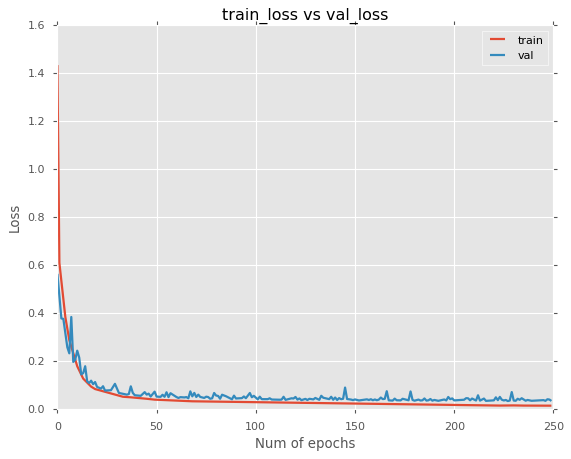

**c) Repita el paso anterior, utilizado ’ReLU’ como función de activación y compare con lo obtenido en b). **

In [ ]:
model2 = Sequential()
model2.add(Dense(256, input_dim=xTrainScaled.shape[1], kernel_initializer='uniform',activation="relu"))
model2.add(Dense(1, kernel_initializer='uniform',activation="linear"))
model2.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error') #, metrics=['accuracy']

history = model2.fit(xTrainScaled.values,
                    yTrain,
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=(xValScaled.values, yVal), 
                    callbacks=[TestCallback((xTestScaled.values, yTest))])

In [ ]:
test_loss[-1] = model2.evaluate(xTestScaled.values, yTest, verbose=0)
train_loss = history.history['loss']
xc = range(numEpochs)
plt.figure(1, figsize=(16, 10))
plt.plot(xc,train_loss)
plt.plot(xc,test_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Training Loss vs Testing Loss')
plt.grid(True)
plt.legend(['Training', 'Validation'])
#print(plt.style.available)
plt.style.use(['ggplot'])

> c) Repita el paso anterior, utilizado ’**ReLU**’ como función de activación y compare con lo obtenido en b).  

```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
#%%El gráfico el error cuadrático (MSE) 
import matplotlib.pyplot as plt
train_loss=history.history['loss']
val_loss=history.history['val_loss']
xc = range(250)
plt.figure(1, figsize=(8,6))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.ylabel('Loss')
plt.xlabel('Num of epochs')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train', 'val'])
#print (plt.style.available)
plt.style.use(['ggplot'])
#%%
```

>El gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de epochs de entrenamiento, para una red feedforward de 3 capas, con 256 unidades ocultas y función de activación sigmoidal. Entrenada la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 250 epochs de entrenamiento, en el conjunto de entrenamiento y de validación.

>**Faltan comentarios!!!**
>Modificando solo esas lineas,este codigo:
```python
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
```
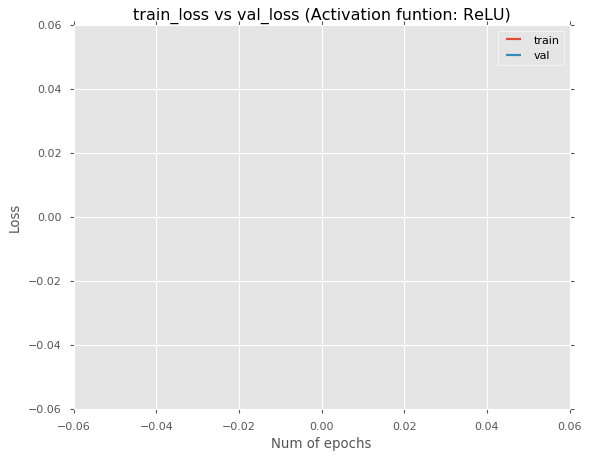


>Con este codigo:
```python
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="relu")) 
```
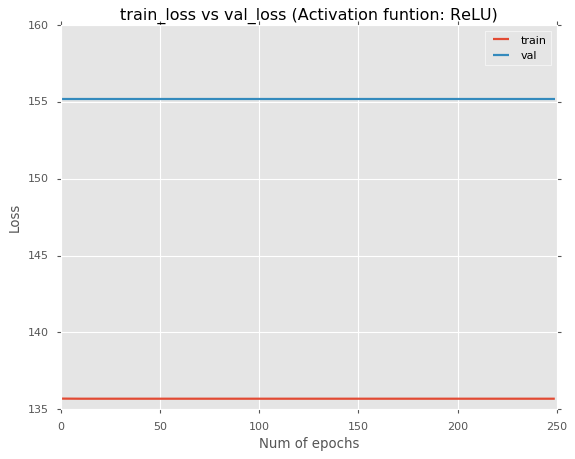

**d) Repita b) y c) variando la tasa de aprendizaje (*learning rate*) en un rango sensible. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.**

In [17]:
def iterateOverLearningRate(n_lr, activ):
    lear_rate = np.linspace(0,1,n_lr)
    histories = np.ndarray((20, ), object)

    for i in range (n_lr):
        model = Sequential()
        model.add(Dense(256, input_dim=xTrainScaled.shape[1], kernel_initializer='uniform',activation=activ))
        model.add(Dense(1, kernel_initializer='uniform',activation="linear"))
        model.compile(optimizer=SGD(lear_rate[i]),loss='mean_squared_error')
        histories[i] = model.fit(xTrainScaled.values,
                        yTrain,
                        epochs=250,
                        verbose=1,
                        validation_data=(xValScaled.values, yVal), 
                        callbacks=[TestCallback((xTestScaled.values, yTest))])
    return histories

Primero, variamos la tasa de aprendizaje del metodo en b)

In [18]:
histories = iterateOverLearningRate(20, "sigmoid")

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9472/9745 [============================>.] - ETA: 0s - loss: 137.0050
Testing loss: 122.1185209628838
9745/9745 [==============================] - 1s - loss: 137.2130 - val_loss: 157.2504
Epoch 2/250
9600/9745 [============================>.] - ETA: 0s - loss: 137.2623
Testing loss: 122.1185209628838
9745/9745 [==============================] - 1s - loss: 137.2130 - val_loss: 157.2504
Epoch 3/250
9376/9745 [===========================>..] - ETA: 0s - loss: 136.8721
Testing loss: 122.1185209628838
9745/9745 [==============================] - 1s - loss: 137.2130 - val_loss: 157.2504
Epoch 4/250
9376/9745 [===========================>..] - ETA: 0s - loss: 137.2969
Testing loss: 122.1185209628838
9745/9745 [==============================] - 1s - loss: 137.2130 - val_loss: 157.2504
Epoch 5/250
9696/9745 [============================>.] - ETA: 0s - loss: 137.1578
Testing loss: 122.1185209628838
9745/9745 [===========================

KeyboardInterrupt: 

Ahora variamos la tasa de aprendizaje del metodo en c)

In [ ]:
histories = iterateOverLearningRate(20, "relu")

**e) Entrene los modelos considerados en b) y c) usando *progressive decay*. Compare y comente.**

In [20]:
def iterateOverDecay(n_decay, activ):
    lear_decay = np.logspace(-6,0,n_decay)
    histories = np.ndarray((n_decay, ), object)
    for i in range (n_decay):
        sgd = SGD(0.2, lear_decay[i])
        model = Sequential()
        model.add(Dense(256, input_dim=xTrainScaled.shape[1], kernel_initializer='uniform',activation=activ))
        model.add(Dense(1, kernel_initializer='uniform',activation="linear"))
        model.compile(optimizer= sgd,loss='mean_squared_error') #, metrics=['accuracy'] 
        histories[i] = model.fit(xTrainScaled.values,
                        yTrain,
                        epochs=20,
                        verbose=1,
                        validation_data=(xValScaled.values, yVal), 
                        callbacks=[TestCallback((xTestScaled.values, yTest))])

Varios el progressive decay para el metodo en b)

In [21]:
histories = iterateOverDecay(10, "sigmoid")

Train on 9745 samples, validate on 4060 samples
Epoch 1/20
9440/9745 [============================>.] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 2/20
9376/9745 [===========================>..] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 3/20
9408/9745 [===========================>..] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 4/20
9696/9745 [============================>.] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 5/20
9376/9745 [===========================>..] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 6/20
9440/9745 [============================>.] - ETA: 0s - loss: nan
Testing loss: nan
9745/974

KeyboardInterrupt: 

In [22]:
histories = iterateOverDecay(10, "relu")

Train on 9745 samples, validate on 4060 samples
Epoch 1/20
9696/9745 [============================>.] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 2/20
9696/9745 [============================>.] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 3/20
9664/9745 [============================>.] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 4/20
9376/9745 [===========================>..] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 5/20
9504/9745 [============================>.] - ETA: 0s - loss: nan
Testing loss: nan
9745/9745 [==============================] - 1s - loss: nan - val_loss: nan
Epoch 6/20
9568/9745 [============================>.] - ETA: 0s - loss: nan
Testing loss: nan
9745/974

KeyboardInterrupt: 